In [4]:
import numpy as np
import matplotlib.pyplot as plt
import KF
from math import *

DATA_FILE = 'EKF_DATA3.txt'

# Read measurements

In [5]:
ekf_data_file = open(DATA_FILE, 'r')
Zraw = []
for line in ekf_data_file:
    if line[0][0] != '%':
        explode_line = line.split(',')
        explode_line[-1] = explode_line[-1][:-2]
        Zraw.append(explode_line)
Zraw = np.array(Zraw, dtype='float')

# Calibrate IMU by the first measurement of odometry (second entry in Z)

In [6]:
delta = float(Zraw[1][3])-float(Zraw[1][4])
Zraw[:,4] += delta # adds delta to every item in column 4 (imu theta)

# Extract velocities from odometry

In [8]:
ini = Zraw[0]
measurements = []
time_step = 1
for i in range(len(Zraw)-1):
    data = {}
    ii = i+1
    timestamp = Zraw[ii][0] #timestamp
    data['timestamp'] = timestamp

    z = []
    z.append(Zraw[ii][5])       # x gps
    z.append(Zraw[ii][6])       # y gps
    z.append(.14)               # Fixed velocity given
    z.append(Zraw[ii][4])       # theta imu
    z.append(.14*tan(Zraw[ii-1][3])) # Angular velocity based on odometry theta
    data['z'] = z

    measurements.append(data)

# Initialize Kalman filter

In [9]:
V = .14     # speed of robot
dt = .001   # time step
A = np.array([[1, 0, dt*V*0, 0, 0],
              [0, 1, dt*V*0, 0, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 0, 1, dt],
              [0, 0, 0, 0, 1]])
B = np.zeros_like(A)
H = np.array([[1, 0, 0, 0, 0],
              [0, 1, 0, 0, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 0, 1]])
Q = np.array([[.00004, 0, 0, 0, 0],
              [0, .00004, 0, 0, 0],
              [0, 0, .00001, 0, 0],
              [0, 0, 0, .00001, 0],
              [0, 0, 0, 0, .00001]])
R = np.array([[.04, 0, 0, 0, 0],
              [0, .04, 0, 0, 0],
              [0, 0, .01, 0, 0],
              [0, 0, 0, .01, 0],
              [0, 0, 0, 0, .01]])
P = np.array([[.01, 0, 0, 0, 0],
              [0, .01, 0, 0, 0],
              [0, 0, .01, 0, 0],
              [0, 0, 0, .01, 0],
              [0, 0, 0, 0, .01]])
x = np.array([[0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0],
              [0, 0, V, 0, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0]])
u = np.zeros_like(x)

In [10]:
kf = KF.KalmanFilter(A,B,H,x,P,Q,R)

# Run

In [11]:
time = []
truevalue = []
measured = []
predicted = []

for data in measurements:
    timestamp = data['timestamp']
    z = data['z']
    time.append(timestamp)
    measured.append(z)
    predicted.append(np.diag(kf.state()))
    theta = np.diag(kf.state())[3]
    A = np.array([[1, 0, dt*V*theta, 0, 0],
                  [0, 1, dt*V*theta, 0, 0],
                  [0, 0, 1, 0, 0],
                  [0, 0, 0, 1, dt],
                  [0, 0, 0, 0, 1]])
    kf.SetA(A)
    kf.iterate(u, z)

time = np.array(time)
truevalue = np.array(truevalue)
measured = np.array(measured)
predicted = np.array(predicted)

## Visualization without Kalman Filter

In [12]:
%matplotlib inline

### Heading

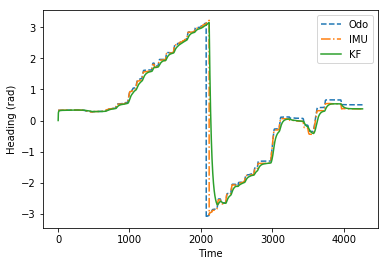

In [19]:
plt.plot(time,Zraw[:,3][1:], marker='None', linestyle='--', label='Odo')
plt.plot(time,Zraw[:,4][1:], marker='None', linestyle='-.', label='IMU')
plt.plot(time,predicted[:,3], marker='None', linestyle='-', label='KF')
plt.legend(['Odo', 'IMU', 'KF'])
plt.ylabel('Heading (rad)')
plt.xlabel('Time')
plt.show()

### Trajectory

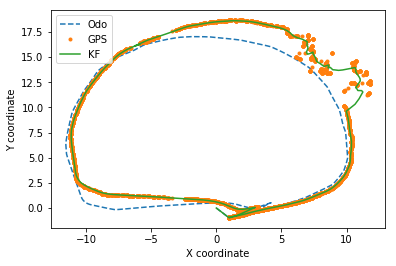

In [20]:
plt.plot(Zraw[:,1],Zraw[:,2], marker='None', linestyle='--')
plt.plot(measured[:,0],measured[:,1], marker='.', linestyle='None')
plt.plot(predicted[:,0], predicted[:,1], marker='None', linestyle='-')
plt.legend(['Odo', 'GPS', 'KF'], loc=2)
plt.ylabel('Y coordinate')
plt.xlabel('X coordinate')
plt.show()

# Odometer

## Low variance

In [21]:
Q = np.array([[.00004, 0, 0, 0, 0],
              [0, .00004, 0, 0, 0],
              [0, 0, .00001, 0, 0],
              [0, 0, 0, .00001, 0],
              [0, 0, 0, 0, .0000001]])

kfLOW = KF.KalmanFilter(A,B,H,x,P,Q,R);

predictedLOW = []

for data in measurements:
    z = data['z']
    predictedLOW.append(np.diag(kfLOW.state()))
    theta = np.diag(kfLOW.state())[3]
    A = np.array([[1, 0, dt*V*theta, 0, 0],
                  [0, 1, dt*V*theta, 0, 0],
                  [0, 0, 1, 0, 0],
                  [0, 0, 0, 1, dt],
                  [0, 0, 0, 0, 1]])
    kfLOW.SetA(A)
    kfLOW.iterate(u, z)
    
predictedLOW = np.array(predictedLOW)

## High variance

In [22]:
Q = np.array([[.00004, 0, 0, 0, 0],
              [0, .00004, 0, 0, 0],
              [0, 0, .00001, 0, 0],
              [0, 0, 0, .00001, 0],
              [0, 0, 0, 0, .001]])

kfHIGH = KF.KalmanFilter(A,B,H,x,P,Q,R);

predictedHIGH = []

for data in measurements:
    z = data['z']
    predictedHIGH.append(np.diag(kfHIGH.state()))
    theta = np.diag(kfHIGH.state())[3]
    A = np.array([[1, 0, dt*V*theta, 0, 0],
                  [0, 1, dt*V*theta, 0, 0],
                  [0, 0, 1, 0, 0],
                  [0, 0, 0, 1, dt],
                  [0, 0, 0, 0, 1]])
    kfHIGH.SetA(A)
    kfHIGH.iterate(u, z)
    
predictedHIGH = np.array(predictedHIGH)

## Visualization

### Heading

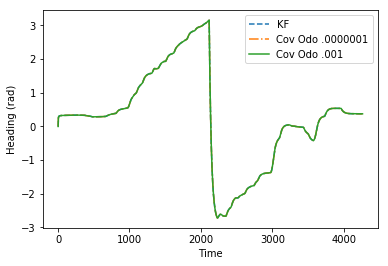

In [26]:
plt.plot(time,predicted[:,3], marker='None', linestyle='--')
plt.plot(time,predictedLOW[:,3], marker='None', linestyle='-.')
plt.plot(time,predictedHIGH[:,3], marker='None', linestyle='-')
plt.legend(['KF', 'Cov Odo .0000001', 'Cov Odo .001'])
plt.ylabel('Heading (rad)')
plt.xlabel('Time')
plt.show()

### Trajectory

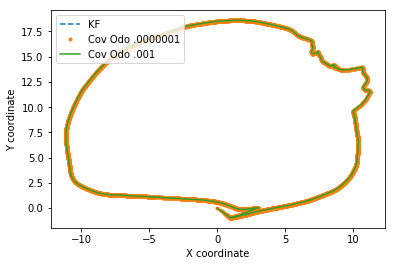

In [27]:
plt.plot(predicted[:,0], predicted[:,1], marker='None', linestyle='--')
plt.plot(predictedLOW[:,0], predictedLOW[:,1], marker='.', linestyle='None')
plt.plot(predictedHIGH[:,0], predictedHIGH[:,1], marker='None', linestyle='-')
plt.legend(['KF', 'Cov Odo .0000001', 'Cov Odo .001'], loc=2)
plt.ylabel('Y coordinate')
plt.xlabel('X coordinate')
plt.show()

# IMU

## Low variance

In [28]:
Q = np.array([[.00004, 0, 0, 0, 0],
              [0, .00004, 0, 0, 0],
              [0, 0, .00001, 0, 0],
              [0, 0, 0, .0000001, 0],
              [0, 0, 0, 0, .00001]])

kfLOW = KF.KalmanFilter(A,B,H,x,P,Q,R);

predictedLOW = []

for data in measurements:
    z = data['z']
    predictedLOW.append(np.diag(kfLOW.state()))
    theta = np.diag(kfLOW.state())[3]
    A = np.array([[1, 0, dt*V*theta, 0, 0],
                  [0, 1, dt*V*theta, 0, 0],
                  [0, 0, 1, 0, 0],
                  [0, 0, 0, 1, dt],
                  [0, 0, 0, 0, 1]])
    kfLOW.SetA(A)
    kfLOW.iterate(u, z)
    
predictedLOW = np.array(predictedLOW)

## High variance

In [29]:
Q = np.array([[.00004, 0, 0, 0, 0],
              [0, .00004, 0, 0, 0],
              [0, 0, .00001, 0, 0],
              [0, 0, 0, .001, 0],
              [0, 0, 0, 0, .00001]])

kfHIGH = KF.KalmanFilter(A,B,H,x,P,Q,R);

predictedHIGH = []

for data in measurements:
    z = data['z']
    predictedHIGH.append(np.diag(kfHIGH.state()))
    theta = np.diag(kfHIGH.state())[3]
    A = np.array([[1, 0, dt*V*theta, 0, 0],
                  [0, 1, dt*V*theta, 0, 0],
                  [0, 0, 1, 0, 0],
                  [0, 0, 0, 1, dt],
                  [0, 0, 0, 0, 1]])
    kfHIGH.SetA(A)
    kfHIGH.iterate(u, z)
    
predictedHIGH = np.array(predictedHIGH)

## Visualization

### Heading

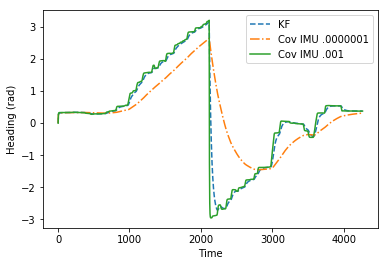

In [31]:
plt.plot(time,predicted[:,3], marker='None', linestyle='--')
plt.plot(time,predictedLOW[:,3], marker='None', linestyle='-.')
plt.plot(time,predictedHIGH[:,3], marker='None', linestyle='-')
plt.legend(['KF', 'Cov IMU .0000001', 'Cov IMU .001'])
plt.ylabel('Heading (rad)')
plt.xlabel('Time')
plt.show()

### Trajectory

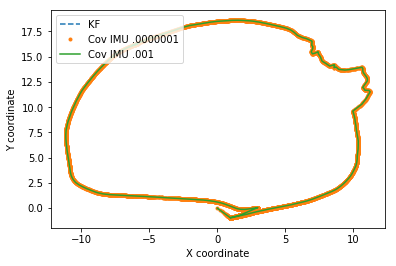

In [32]:
plt.plot(predicted[:,0], predicted[:,1], marker='None', linestyle='--')
plt.plot(predictedLOW[:,0], predictedLOW[:,1], marker='.', linestyle='None')
plt.plot(predictedHIGH[:,0], predictedHIGH[:,1], marker='None', linestyle='-')
plt.legend(['KF', 'Cov IMU .0000001', 'Cov IMU .001'], loc=2)
plt.ylabel('Y coordinate')
plt.xlabel('X coordinate')
plt.show()

# GPS

## Low variance

In [33]:
Q = np.array([[.000004, 0, 0, 0, 0],
              [0, .000004, 0, 0, 0],
              [0, 0, .00001, 0, 0],
              [0, 0, 0, .00001, 0],
              [0, 0, 0, 0, .00001]])

kfLOW = KF.KalmanFilter(A,B,H,x,P,Q,R);

predictedLOW = []

for data in measurements:
    z = data['z']
    predictedLOW.append(np.diag(kfLOW.state()))
    theta = np.diag(kfLOW.state())[3]
    A = np.array([[1, 0, dt*V*theta, 0, 0],
                  [0, 1, dt*V*theta, 0, 0],
                  [0, 0, 1, 0, 0],
                  [0, 0, 0, 1, dt],
                  [0, 0, 0, 0, 1]])
    kfLOW.SetA(A)
    kfLOW.iterate(u, z)
    
predictedLOW = np.array(predictedLOW)

## High variance

In [34]:
Q = np.array([[.04, 0, 0, 0, 0],
              [0, .04, 0, 0, 0],
              [0, 0, .00001, 0, 0],
              [0, 0, 0, .00001, 0],
              [0, 0, 0, 0, .00001]])

kfHIGH = KF.KalmanFilter(A,B,H,x,P,Q,R);

predictedHIGH = []

for data in measurements:
    z = data['z']
    predictedHIGH.append(np.diag(kfHIGH.state()))
    theta = np.diag(kfHIGH.state())[3]
    A = np.array([[1, 0, dt*V*theta, 0, 0],
                  [0, 1, dt*V*theta, 0, 0],
                  [0, 0, 1, 0, 0],
                  [0, 0, 0, 1, dt],
                  [0, 0, 0, 0, 1]])
    kfHIGH.SetA(A)
    kfHIGH.iterate(u, z)
    
predictedHIGH = np.array(predictedHIGH)

## Visualization

### Heading

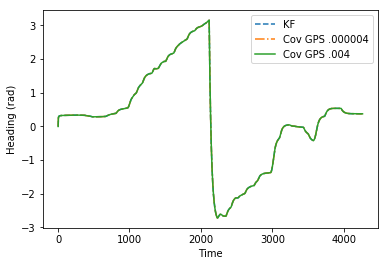

In [35]:
plt.plot(time,predicted[:,3], marker='None', linestyle='--')
plt.plot(time,predictedLOW[:,3], marker='None', linestyle='-.')
plt.plot(time,predictedHIGH[:,3], marker='None', linestyle='-')
plt.legend(['KF', 'Cov GPS .000004', 'Cov GPS .004'])
plt.ylabel('Heading (rad)')
plt.xlabel('Time')
plt.show()

### Trajectory

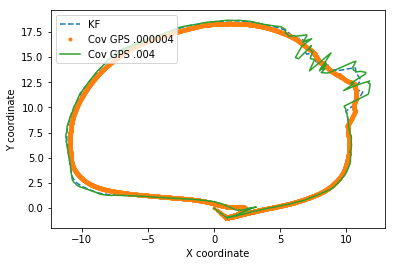

In [36]:
plt.plot(predicted[:,0], predicted[:,1], marker='None', linestyle='--')
plt.plot(predictedLOW[:,0], predictedLOW[:,1], marker='.', linestyle='None')
plt.plot(predictedHIGH[:,0], predictedHIGH[:,1], marker='None', linestyle='-')
plt.legend(['KF', 'Cov GPS .000004', 'Cov GPS .004'], loc=2)
plt.ylabel('Y coordinate')
plt.xlabel('X coordinate')
plt.show()